# Olist E-commerce Business Analysis

| **Field** | **Value** |
|-----------|------------|
| **Author** | Mubin |
| **Domain** | E-commerce / Data Science |
| **Python** | 3.13.5 |
| **Data Source** | [Olist Brazilian E-Commerce](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) |

**Tools:** Python, Pandas, NumPy, Seaborn, Matplotlib, Folium.

---

## Table of Contents
1. Environment Setup & Data Loading  
2. Dataset Overview & Data Quality  
3. Sales Trend & Temporal Analysis  
4. Delivery Performance & Logistics  
5. Customer Segmentation (RFM)  
6. Product Quality Analysis  
7. Payment Behaviour Analysis  
8. Top Seller Analysis  
9. Geospatial Analysis  
10. Conclusions & Strategic Recommendations  

---

## Project Objective
The goal of this project is to analyze the Olist E-commerce dataset to derive **actionable business insights**. We focus on:

1. **Logistics Performance** — Identifying delays and shipping issues.  
2. **Customer Segmentation** — Finding high-value customers using RFM.  
3. **Sales Trends** — Understanding seasonality and peak hours.  
4. **Product Quality** — Spotting low-rated categories and improvement opportunities.

---

## 1. Environment Setup & Data Loading

This section ensures **reproducibility** and a clean analysis environment:
- Import core libraries (pandas, numpy, matplotlib, seaborn, folium).
- Set global constants (e.g. `RANDOM_STATE`, `DATA_PATH`).
- Configure display and plotting defaults.
- Load and validate all necessary Olist E-commerce datasets.

**Reproducibility:** Place Olist CSVs in `data/` and install dependencies with  
`pip install -r requirements-olist.txt`.


In [1]:
# --- Environment Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os
import sys
import warnings
from textblob import TextBlob
from folium.plugins import HeatMap
from IPython.display import display_html

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Plot style (if needed)
# sns.set_theme(style="whitegrid", font_scale=1.1)
# plt.rcParams['figure.figsize'] = (10, 5)
# plt.rcParams['font.size'] = 11

# Version check (for reproducibility)
print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")

Python: 3.13.5
Pandas: 3.0.0


In [2]:
# --- Load Datasets ---
from typing import Optional

DATA_PATH = 'data/'

def load_data(file_name: str) -> Optional[pd.DataFrame]:
    """Load a CSV from DATA_PATH. Returns None and prints error if file not found."""
    path = os.path.join(DATA_PATH, file_name)
    try:
        return pd.read_csv(path)
    except FileNotFoundError:
        print(f"Error: File {file_name} not found in {DATA_PATH}")
        return None

# Load all datasets
orders_df = load_data('olist_orders_dataset.csv')
customers_df = load_data('olist_customers_dataset.csv')
items_df = load_data('olist_order_items_dataset.csv')
products_df = load_data('olist_products_dataset.csv')
payments_df = load_data('olist_order_payments_dataset.csv')
reviews_df = load_data('olist_order_reviews_dataset.csv')
category_translation = load_data('product_category_name_translation.csv')
geo_data = load_data('olist_geolocation_dataset.csv')
sellers_df = load_data('olist_sellers_dataset.csv')

# Validate critical datasets
required = {
    'orders': orders_df,
    'customers': customers_df,
    'order_items': items_df,
    'products': products_df,
    'payments': payments_df,
}
missing = [k for k, v in required.items() if v is None or v.empty]
if missing:
    raise FileNotFoundError(f"Required datasets missing or empty: {missing}. Ensure 'data/' contains Olist CSVs.")
print("All required datasets loaded successfully.")

All required datasets loaded successfully.


## 2. Dataset Overview & Data Quality

We inspect schema, dtypes, non-null counts, and missing values for each table. Order status distribution is also summarized to understand the business mix.

In [3]:
all_datasets = {
    'Orders': orders_df,
    'Customers': customers_df,
    'Items': items_df,
    'Products': products_df,
    'Payments': payments_df,
    'Reviews': reviews_df,
    'Category (Eng.)': category_translation,
    'Geolocation': geo_data,
    'Sellers': sellers_df
}
def get_info_summary(df):
    return pd.DataFrame({
        'Dtype': df.dtypes.astype(str),
        'Non-Null': df.count(),
        'Missing': df.isnull().sum()
    })

# Loop and create HTML for each dataset
html_output = ""
for name, df in all_datasets.items():
    info_df = get_info_summary(df)
    
    styler = info_df.style \
        .set_table_attributes("style='display:inline-block; vertical-align: top; margin: 0px 30px 20px 0px;'") \
        .set_caption(f"<b>🔹 {name} ({df.shape[0]} rows, {df.shape[1]} cols)</b>") \
        .background_gradient(cmap='Reds', subset=['Missing'])  # Highlight missing values in Red       
    html_output += styler._repr_html_()

status_df = orders_df['order_status'].value_counts().to_frame(name='Count')
status_styler = status_df.style \
    .set_table_attributes("style='display:inline-block; vertical-align: top; margin: 0px 30px 20px 0px;'") \
    .set_caption("<b>🔹 Order Status Distribution</b>") \
    .background_gradient(cmap='Blues') \
    .format("{:,}")
html_output += status_styler._repr_html_()

# Showing all tables
print("Dataset Summaries (Info & Types):")
display_html(html_output, raw=True)

Dataset Summaries (Info & Types):


,Dtype,Non-Null,Missing
order_id,str,99441,0
customer_id,str,99441,0
order_status,str,99441,0
order_purchase_timestamp,str,99441,0
order_approved_at,str,99281,160
order_delivered_carrier_date,str,97658,1783
order_delivered_customer_date,str,96476,2965
order_estimated_delivery_date,str,99441,0
,Dtype,Non-Null,Missing
customer_id,str,99441,0


In [4]:
# Convert date columns in orders_df to datetime format
date_columns = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]
for col in date_columns:
    orders_df[col] = pd.to_datetime(orders_df[col])

# Verify the changes
orders_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  str           
 1   customer_id                    99441 non-null  str           
 2   order_status                   99441 non-null  str           
 3   order_purchase_timestamp       99441 non-null  datetime64[us]
 4   order_approved_at              99281 non-null  datetime64[us]
 5   order_delivered_carrier_date   97658 non-null  datetime64[us]
 6   order_delivered_customer_date  96476 non-null  datetime64[us]
 7   order_estimated_delivery_date  99441 non-null  datetime64[us]
dtypes: datetime64[us](5), str(3)
memory usage: 13.0 MB


## 3. Sales Trend & Temporal Analysis
Understanding the sales trend over time helps in inventory planning and marketing strategies. We will analyze:
1. **Monthly Sales Trend** , 2. **Sales Heatmap** 

###  Monthly Sales Trend & Seasonality
We analyze the timeline of total revenue to identify growth patterns and seasonality.
> **Visualization Note:** Data from the initial launch phase (2016) and the incomplete records of September 2018 have been excluded from this chart to present a strictly accurate trend without misleading drop-offs.

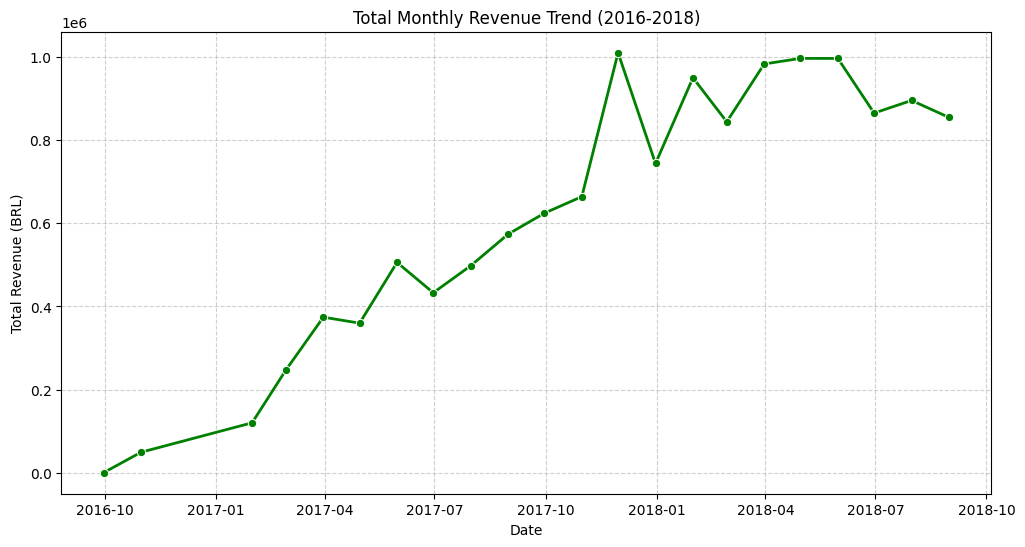

order_purchase_timestamp,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30
Total Revenue,267.360,49507.660,0.000,10.900,120312.870,247303.020,374344.300,359927.230,506071.140,433038.600,498031.480,573971.680,624401.690,664219.430,1010271.370,743914.170,950030.360,844178.710,983213.440,996647.750,996517.680,865124.310,895507.220,854686.330,145.000


In [5]:
# Preparing Monthly Revenue Data
sales_data = orders_df.merge(items_df, on='order_id')
sales_data['order_purchase_timestamp'] = pd.to_datetime(sales_data['order_purchase_timestamp'])
sales_data.set_index('order_purchase_timestamp', inplace=True)
monthly_revenue = sales_data.resample('ME')['price'].sum()

# Filtering out months with unrealistic low revenue
filtered_monthly_revenue = monthly_revenue[monthly_revenue > 200]

# Visualizing the Trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=filtered_monthly_revenue.index, y=filtered_monthly_revenue.values, marker='o', color='green', linewidth=2)
plt.title('Total Monthly Revenue Trend (2016-2018)')
plt.xlabel('Date')
plt.ylabel('Total Revenue (BRL)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

display(monthly_revenue.to_frame('Total Revenue').T)

### **Sales Heatmap:** 
To pinpoint the specific days of the week and hours of the day when customers are most active.

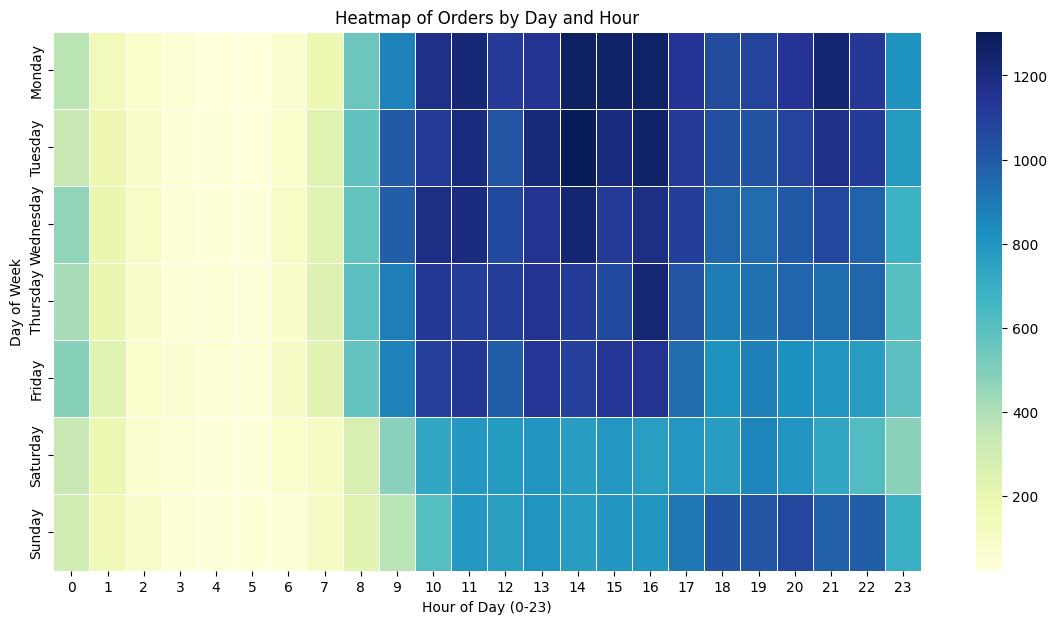

In [6]:
# Preparing Data for Heatmap
sales_data.reset_index(inplace=True)
sales_data['day_name'] = sales_data['order_purchase_timestamp'].dt.day_name()
sales_data['hour'] = sales_data['order_purchase_timestamp'].dt.hour

# Ordering the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_data['day_name'] = pd.Categorical(sales_data['day_name'], categories=days_order, ordered=True)

# Creating a Pivot Table: Rows = Days, Columns = Hours, Values = Count of Orders
pivot_table = sales_data.pivot_table(index='day_name', columns='hour', values='order_id', aggfunc='count')

# Visualizing with Heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(pivot_table, cmap='YlGnBu', linecolor='white', linewidths=0.5)
plt.title('Heatmap of Orders by Day and Hour')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Day of Week')
plt.show()

## 4. Delivery Performance & Logistics Analysis
In this section, we will analyze the delivery efficiency. We will calculate the difference between the estimated delivery date and the actual delivery date to identify delays. Then, we will correlate these delays with customer review scores to understand the impact of logistics on customer satisfaction.


Timely delivery is a critical factor in customer satisfaction and retention. In this section, we evaluate the logistics efficiency by comparing the actual delivery date against the estimated delivery date.

In [7]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


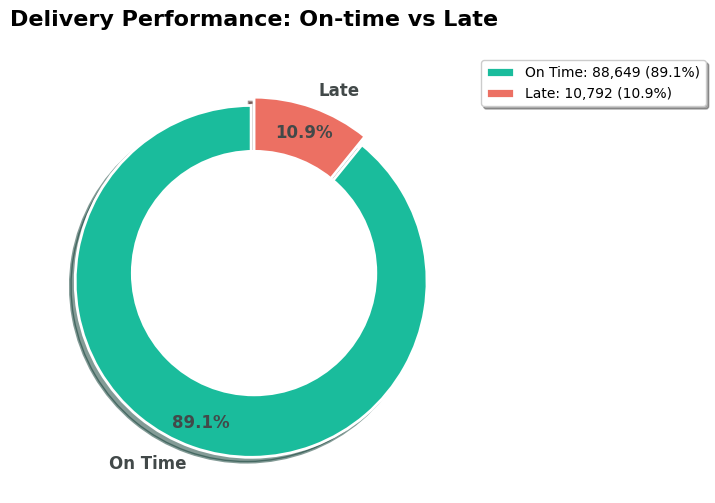

In [8]:
# Enhanced On-time Delivery Rate
orders_df['delivered_on_time'] = orders_df['order_delivered_customer_date'] <= orders_df['order_estimated_delivery_date']       
on_time_counts = orders_df['delivered_on_time'].value_counts().sort_index(ascending=False)

labels = ['On Time', 'Late']
colors = ['#1ABC9C', '#EC7063'] 
explode = (0.05, 0)

# Visualization
plt.figure(figsize=(7, 7))
plt.pie(on_time_counts, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, pctdistance=0.85, explode=explode,
        textprops={'fontsize': 12, 'weight': 'bold', 'color': '#424949'},
        wedgeprops={'width': 0.6, 'edgecolor': 'white', 'linewidth': 2}, shadow=True)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

total = sum(on_time_counts)
legend_labels = [f'{label}: {size:,} ({size/total*100:.1f}%)' 
                 for label, size in zip(labels, on_time_counts)]

plt.legend(legend_labels, 
          loc='upper left', 
          bbox_to_anchor=(1, 1),
          fontsize=10,
          frameon=True,
          shadow=True)

plt.title('Delivery Performance: On-time vs Late', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('Olist_Ecommerce_Analysis_13_0.png', dpi=300, bbox_inches='tight')
plt.show()

### Average Delivery Time by State

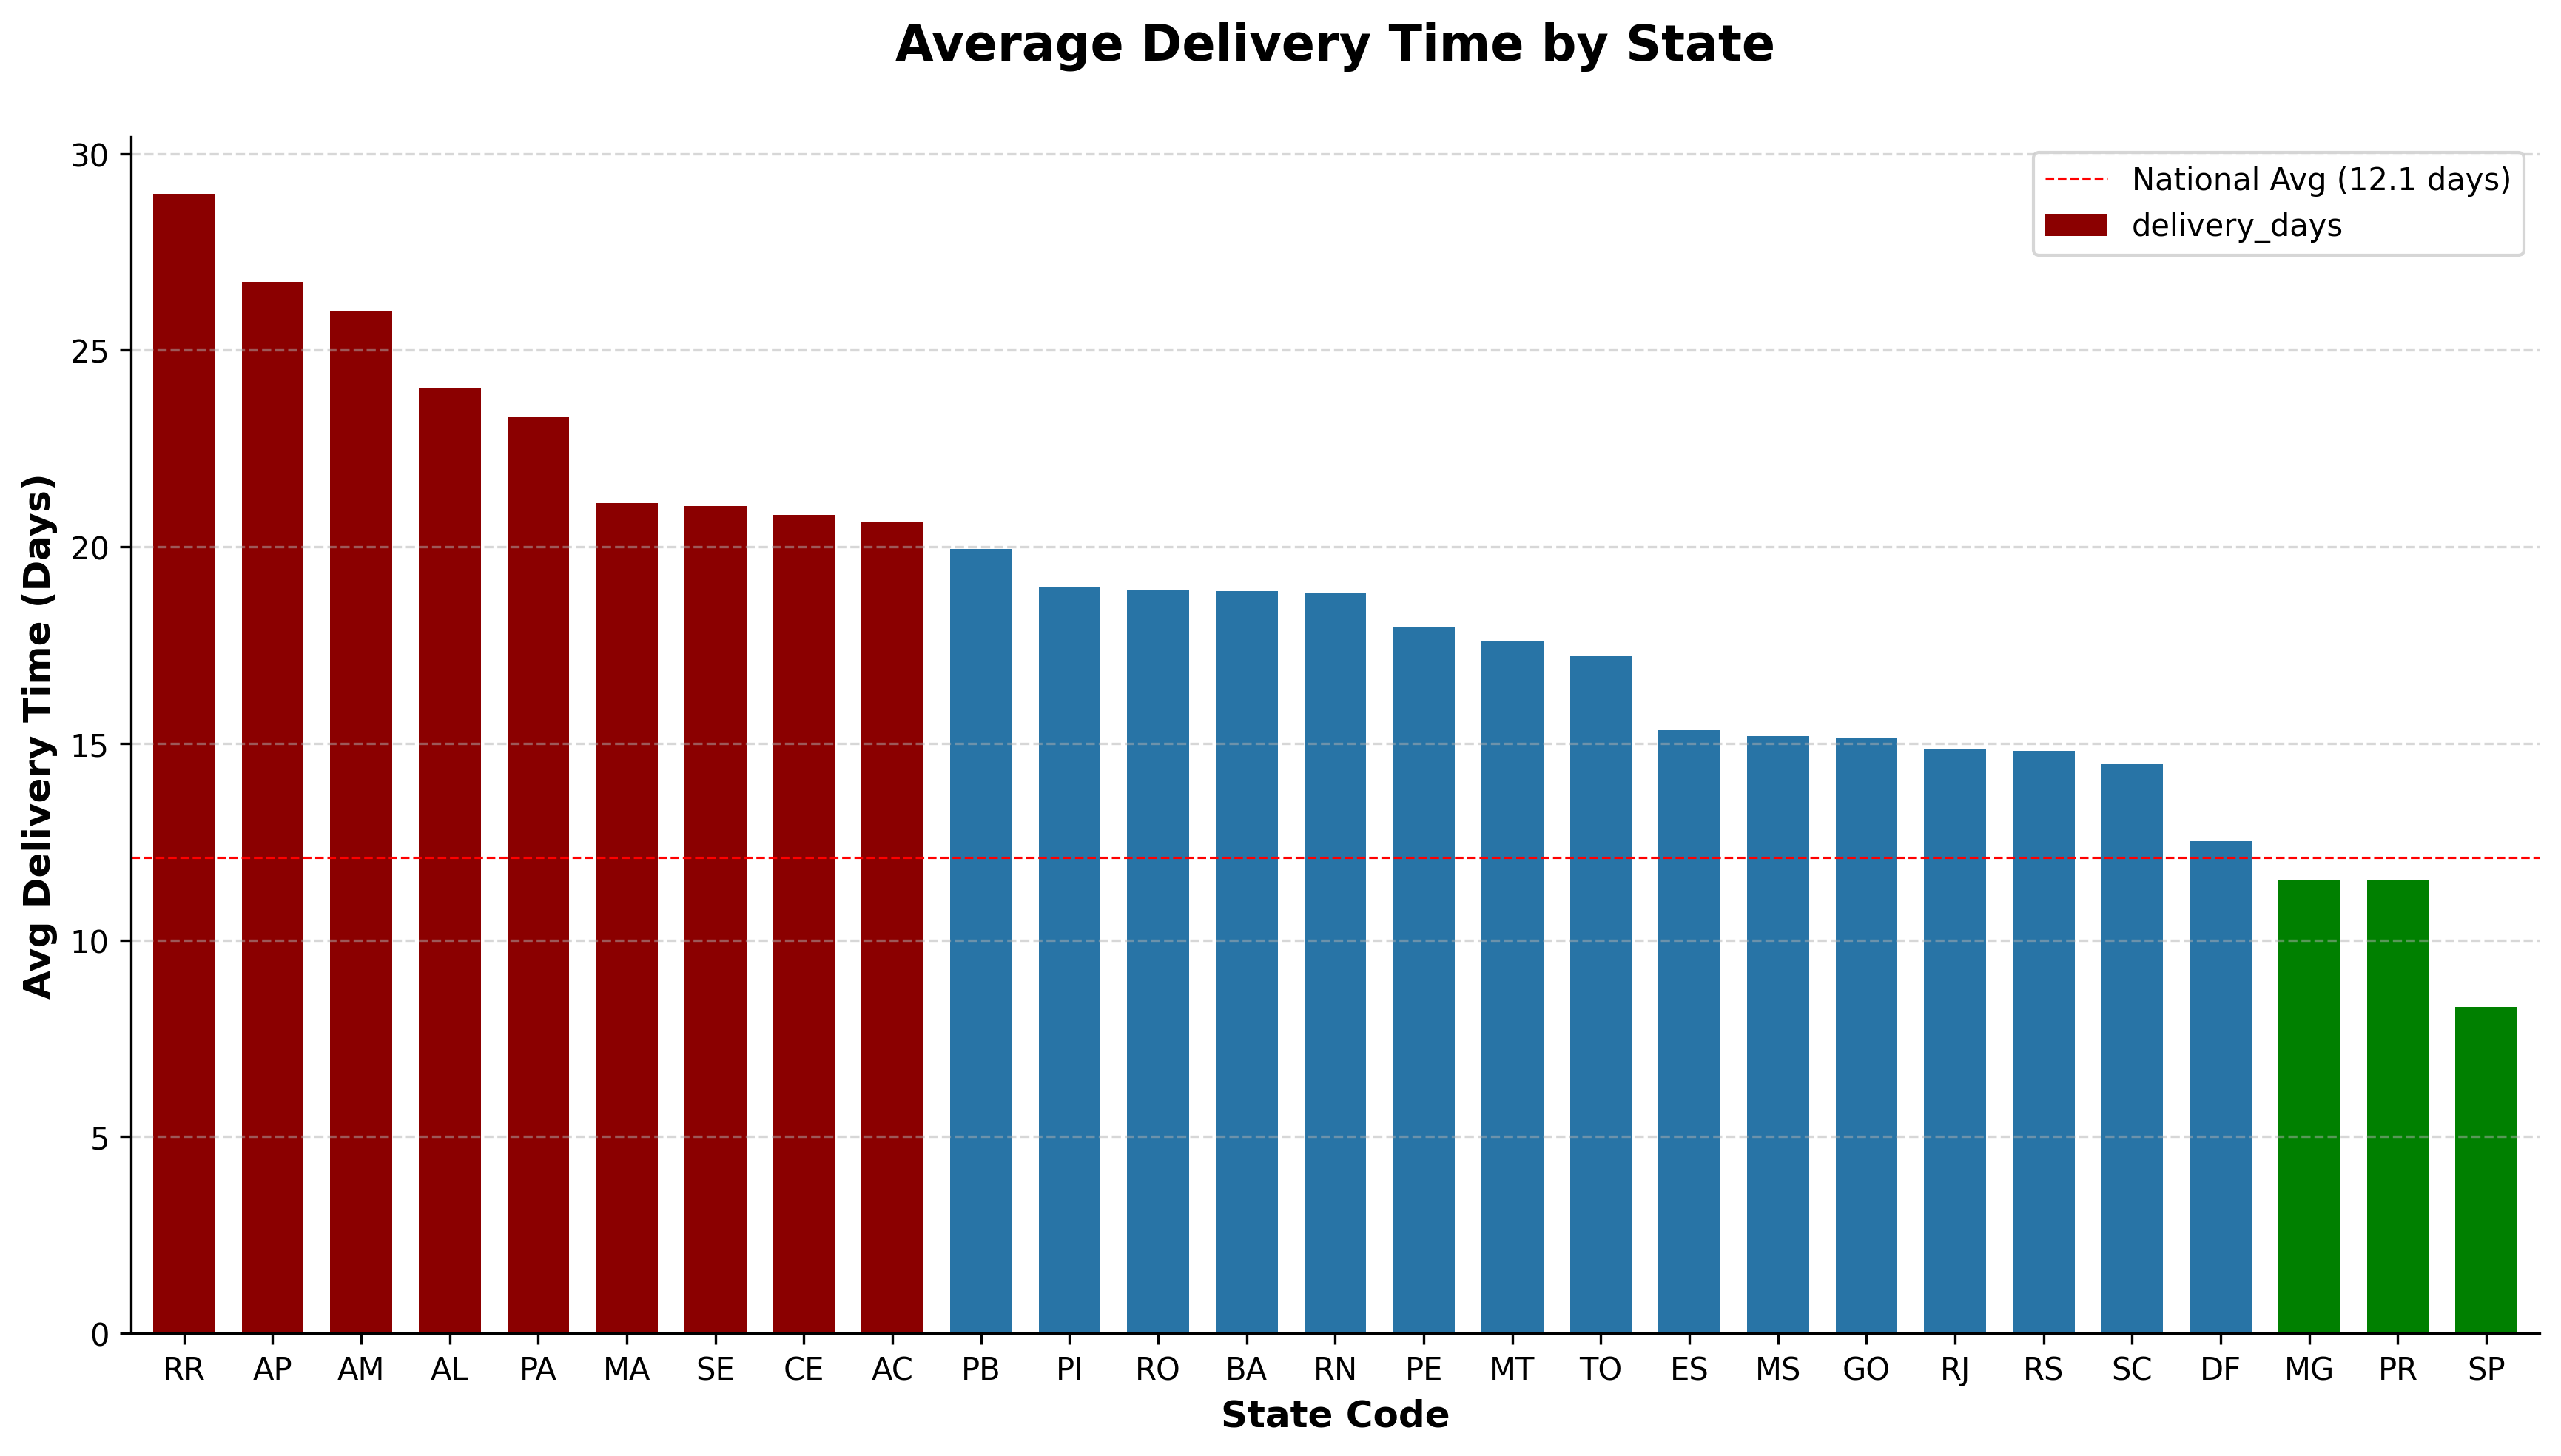

In [9]:
# Prepare Data
orders_df['delivery_days'] = (orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']).dt.days
delivery_data = orders_df.merge(customers_df, on='customer_id')
state_delivery = delivery_data.groupby('customer_state')['delivery_days'].mean().sort_values(ascending=False)
national_avg = delivery_data['delivery_days'].mean()

# Visualization
colors = [
    'green' if x < national_avg 
    else '#8B0000' if x >= 20 
    else '#2874A6'
    for x in state_delivery
]
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)
state_delivery.plot(kind='bar', color=colors, ax=ax, width=0.7)
plt.axhline(y=national_avg, color='red', linestyle='--', linewidth=0.75, label=f'National Avg ({national_avg:.1f} days)')

# Styling
ax.set_title("Average Delivery Time by State", fontsize=16, fontweight='bold', pad=25)
ax.set_ylabel("Avg Delivery Time (Days)", fontsize=12, fontweight='bold')
ax.set_xlabel("State Code", fontsize=12, fontweight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend()
plt.xticks(rotation=0)

sns.despine(top=True, right=True)
plt.show()

### Late Delivery Rate by State (Failure Analysis)
Instead of relying on average delivery times which can hide performance issues, we analyze the **Percentage of Late Deliveries**.
* **Metric:** % of Orders Delivered Late (**Actual Delivery Date > Estimated Delivery Date**).
* **Business Value:** identifying high-risk regions where logistics frequently fail to meet customer expectations.

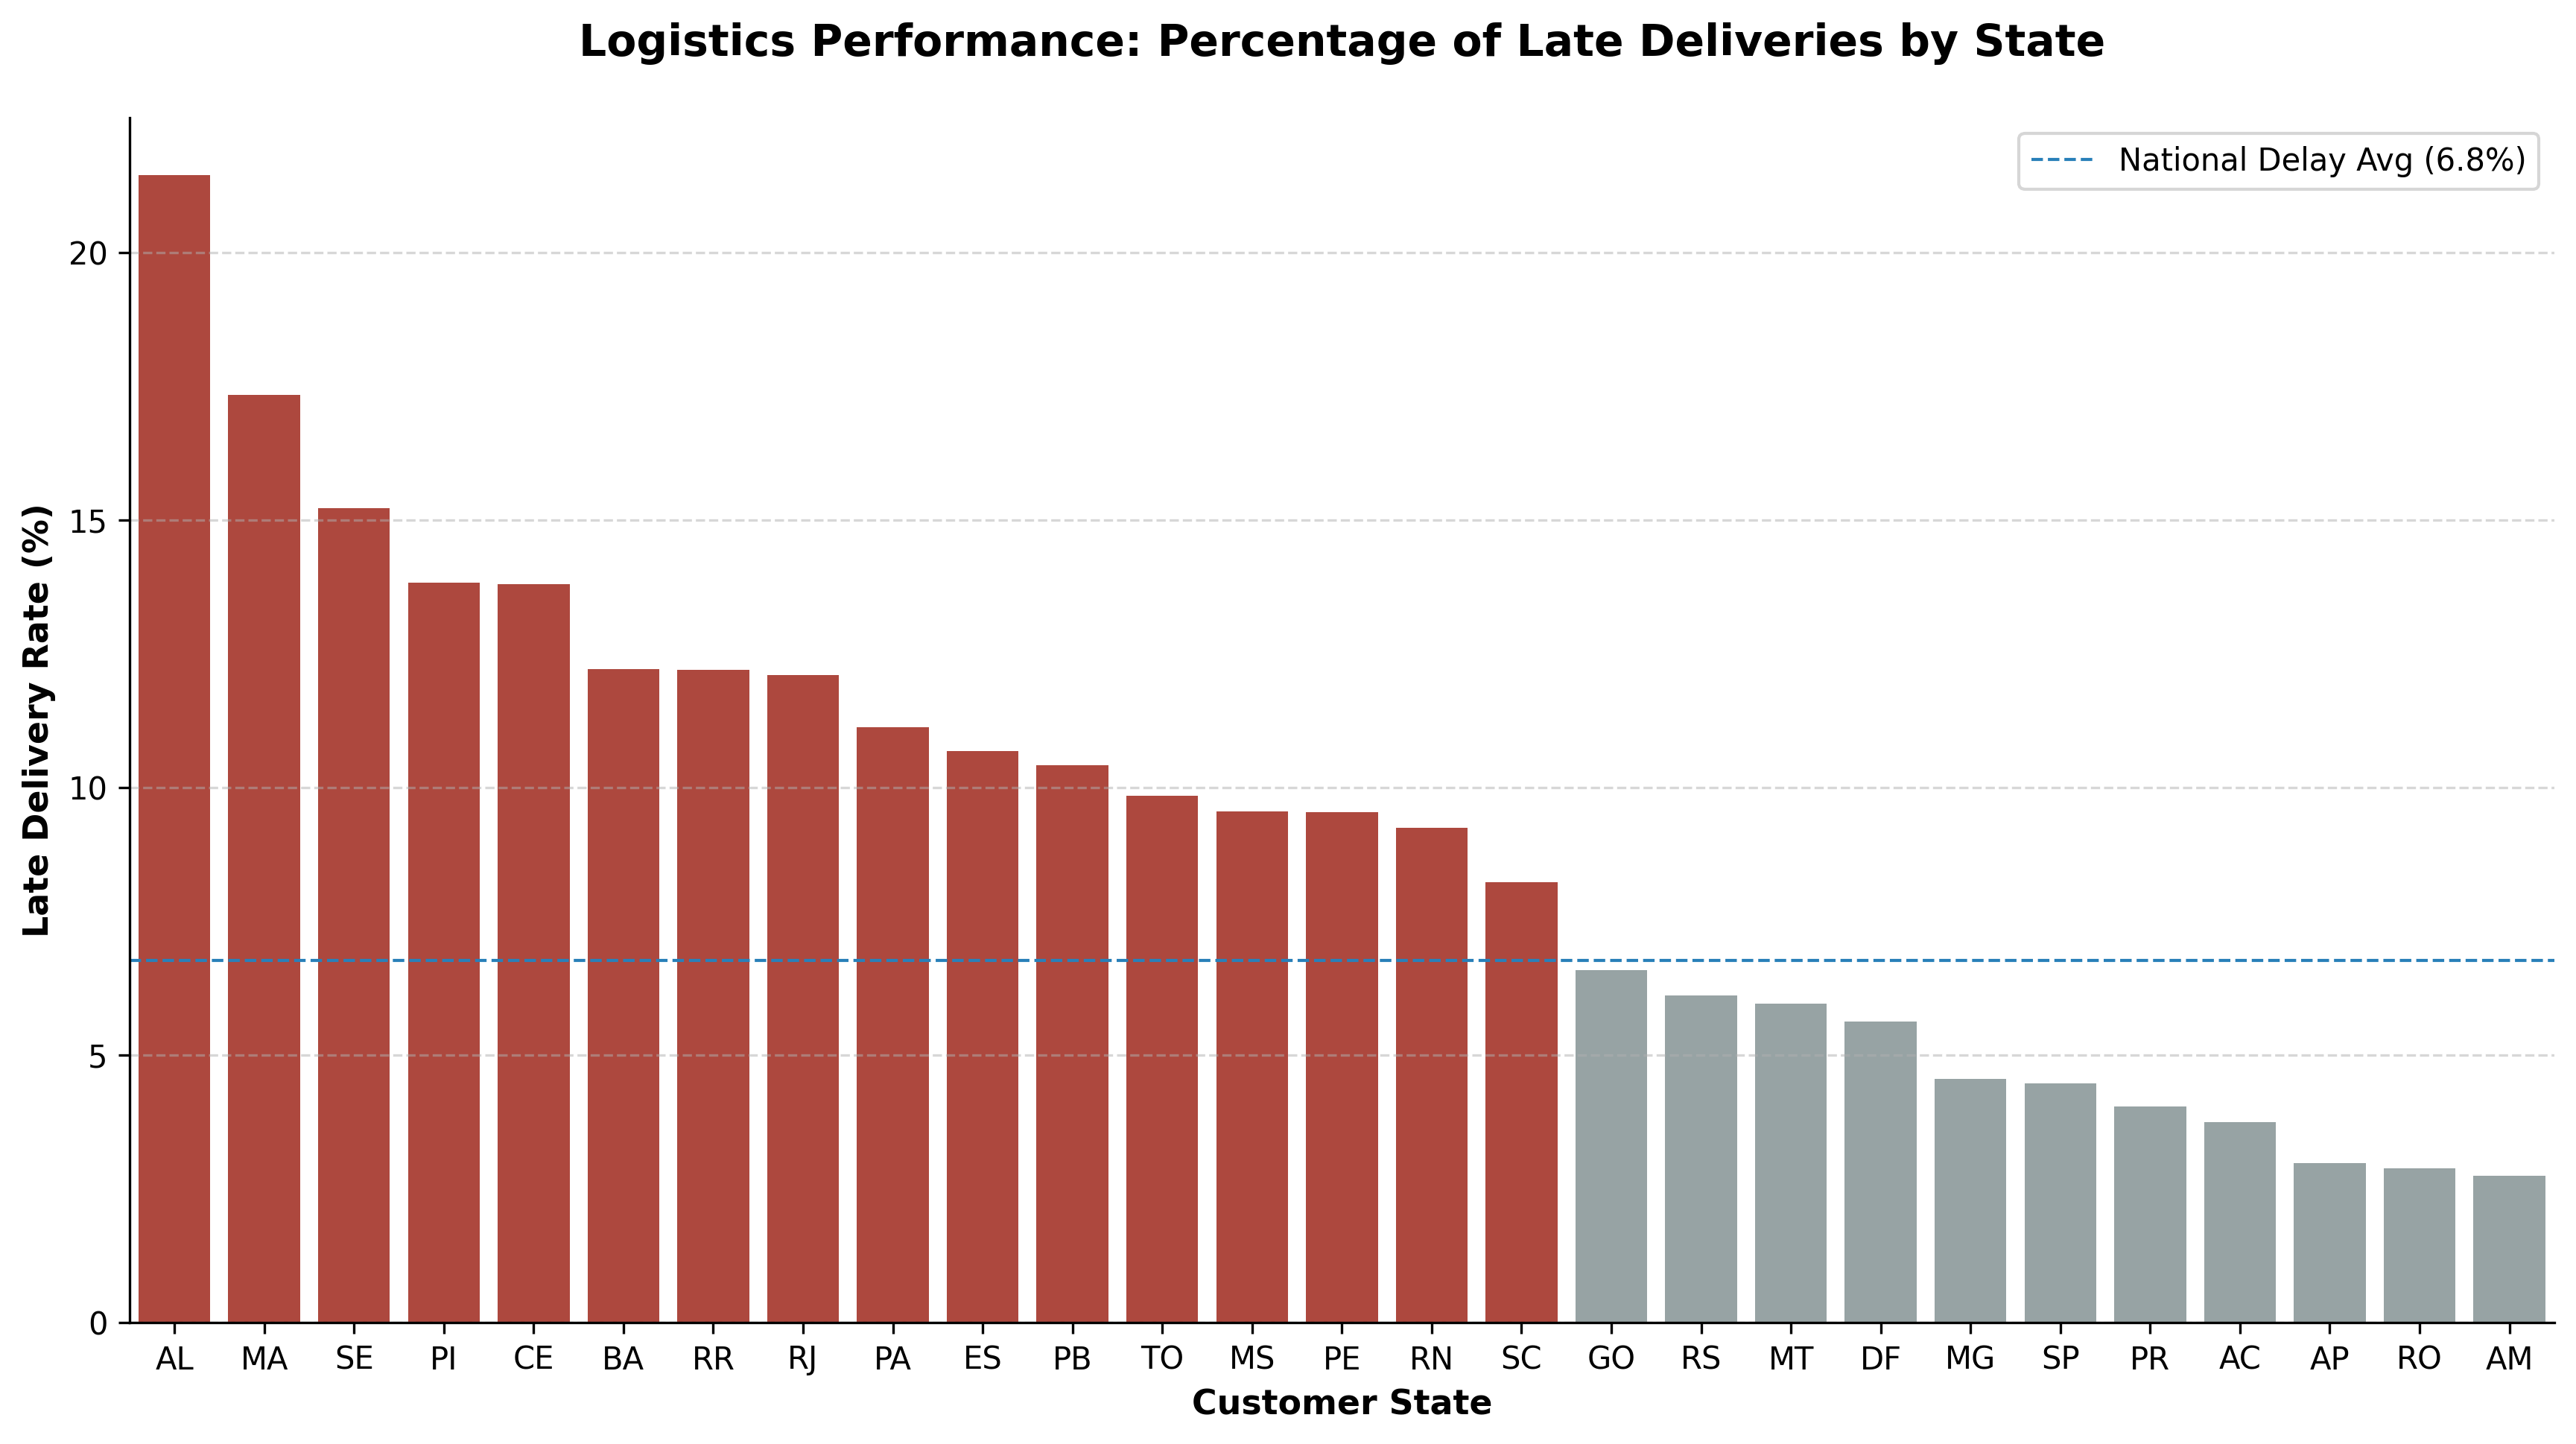

In [10]:
# Prepare Data & Calculate Delay
delivery_analysis_df = orders_df.merge(reviews_df, on='order_id', how='left') \
                                .merge(customers_df, on='customer_id', how='left')
delivery_analysis_df = delivery_analysis_df[delivery_analysis_df['order_status'] == 'delivered']
delivery_analysis_df.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'], inplace=True)
delivery_analysis_df['delivery_difference'] = (delivery_analysis_df['order_delivered_customer_date'] - 
                                               delivery_analysis_df['order_estimated_delivery_date']).dt.days
delivery_analysis_df['is_late'] = delivery_analysis_df['delivery_difference'] > 0
late_rate_by_state = delivery_analysis_df.groupby('customer_state')['is_late'].mean().sort_values(ascending=False) * 100
national_avg = delivery_analysis_df['is_late'].mean() * 100

# Visualization
plt.figure(figsize=(14, 7), dpi=300)
ax = sns.barplot(
    x=late_rate_by_state.index, 
    y=late_rate_by_state.values, 
    palette=['#C0392B' if x > national_avg else '#95A5A6' for x in late_rate_by_state.values]
)
# Chart Titles and Labels
plt.title('Logistics Performance: Percentage of Late Deliveries by State', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Late Delivery Rate (%)', fontsize=11, fontweight='bold')
plt.xlabel('Customer State', fontsize=11, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding National Average Reference Line
plt.axhline(national_avg, color='#2980B9', linestyle='--', linewidth=1, label=f'National Delay Avg ({national_avg:.1f}%)')
plt.legend()

sns.despine()
plt.show()

----

### **Worst Performing Sellers (Logistics Issue)**
Identifying sellers who consistently miss their shipping deadlines. If a seller hands over the package to the carrier late, the final delivery will inevitably be delayed.

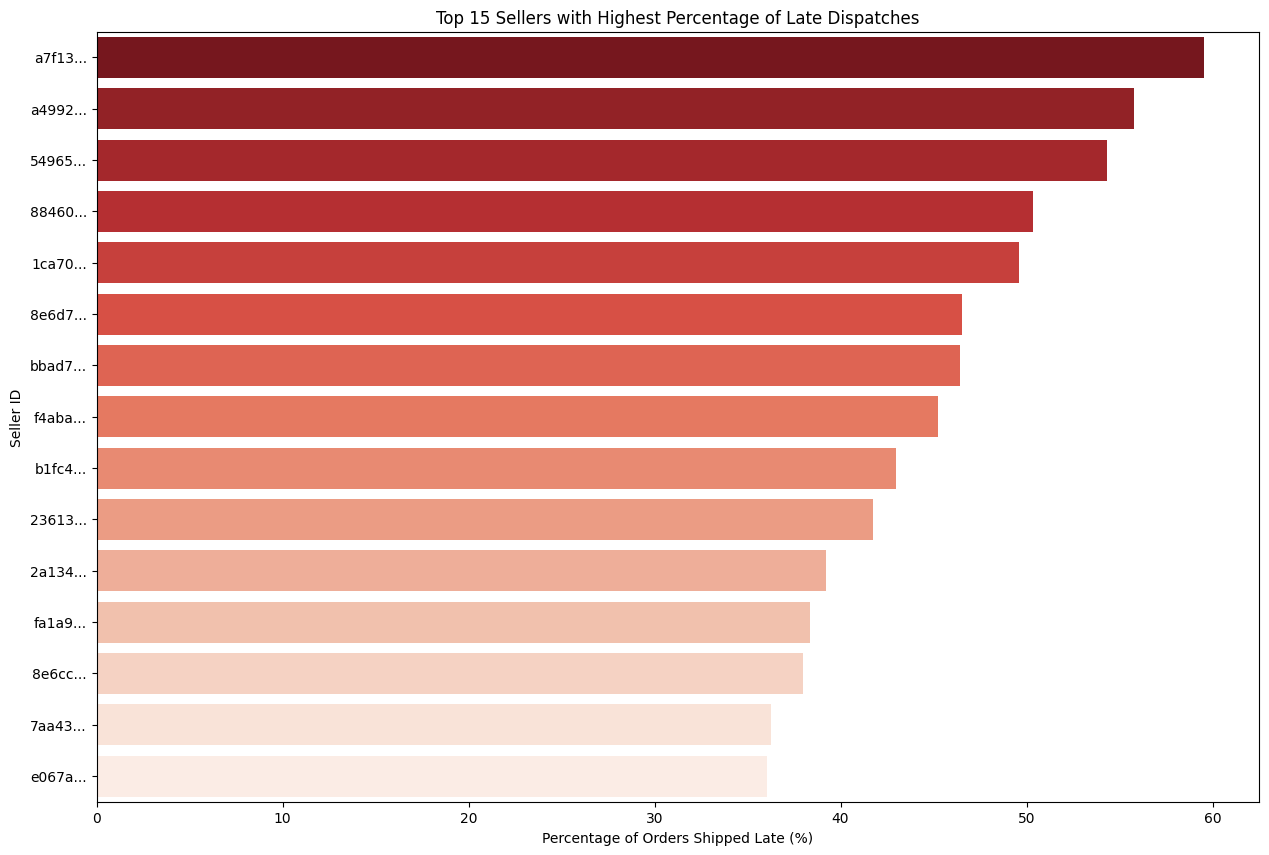

In [11]:
# Identifying Worst Sellers Based on Late Dispatches
seller_delay_df = orders_df.merge(items_df, on='order_id')
seller_delay_df = seller_delay_df[seller_delay_df['order_status'] == 'delivered']
seller_delay_df.dropna(subset=['order_delivered_carrier_date'], inplace=True)
seller_delay_df['seller_late_dispatch'] = seller_delay_df['order_delivered_carrier_date'] > seller_delay_df['shipping_limit_date']

worst_sellers = seller_delay_df.groupby('seller_id').agg({
    'order_id': 'count',
    'seller_late_dispatch': 'sum'
}).reset_index()
worst_sellers['late_percentage'] = (worst_sellers['seller_late_dispatch'] / worst_sellers['order_id']) * 100
worst_sellers = worst_sellers[worst_sellers['order_id'] > 50]
top_worst_sellers = worst_sellers.sort_values('late_percentage', ascending=False).head(15)

# Shortening ID for graph
top_worst_sellers['short_id'] = top_worst_sellers['seller_id'].str[:5] + '...'

# --- 4. Visualizing ---
plt.figure(figsize=(15, 10))
sns.barplot(x='late_percentage', y='short_id', data=top_worst_sellers, palette='Reds_r')

plt.title('Top 15 Sellers with Highest Percentage of Late Dispatches')
plt.xlabel('Percentage of Orders Shipped Late (%)')
plt.ylabel('Seller ID')
plt.show()

# Exporting Results in Excel
top_worst_sellers.to_excel('worst_sellers_statistics(by late_dispatch).xlsx', index=False)

### Impact of Late Delivery on Customer Satisfaction
In this section, we quantify the "cost" of logistics failures. We compare the **Average Review Score** of orders delivered on time versus those delivered late to measure exactly how much delays penalize the brand's reputation.

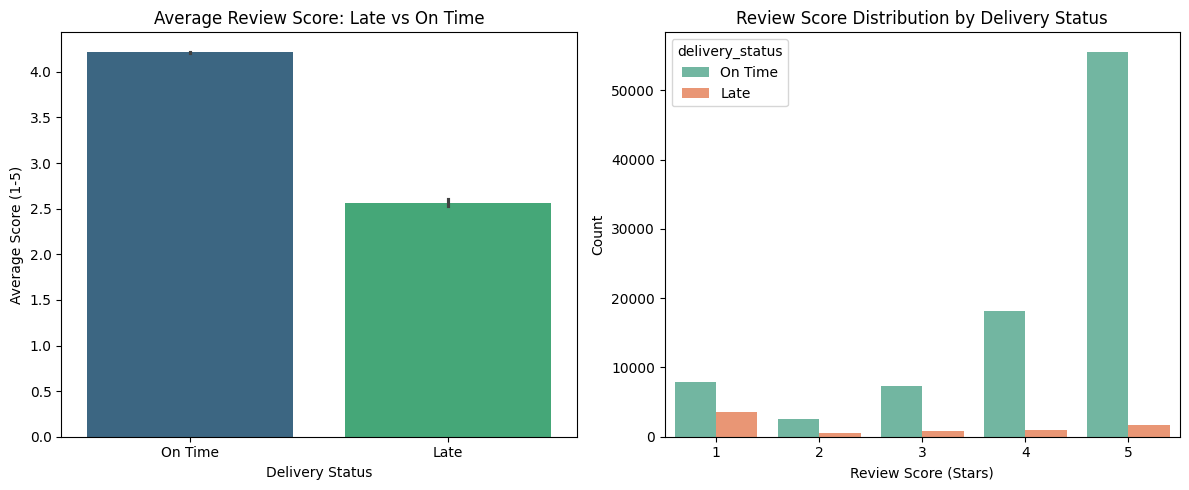

In [12]:
# Ensure is_late exists before using it
if 'is_late' not in orders_df.columns:
	orders_df['is_late'] = (
		orders_df['order_delivered_customer_date'] > orders_df['order_estimated_delivery_date'])
	
orders_df['delivery_status'] = orders_df['is_late'].apply(lambda x: 'Late' if x else 'On Time')
merged_df = pd.merge(reviews_df, orders_df, on='order_id')

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='delivery_status', y='review_score', data=merged_df, palette='viridis')
plt.title('Average Review Score: Late vs On Time')
plt.xlabel('Delivery Status')
plt.ylabel('Average Score (1-5)')

plt.subplot(1, 2, 2)
sns.countplot(x='review_score', hue='delivery_status', data=merged_df, palette='Set2')
plt.title('Review Score Distribution by Delivery Status')
plt.xlabel('Review Score (Stars)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### **Late Delivery Review Score Validation**
#### Logic: **Average Sentiment Score**
**Polarity Scoring:** Text data is processed via NLP algorithms to assign a numerical coefficient ranging from -1.0 (Negative) to +1.0 (Positive) based on lexical sentiment patterns.                  
**Aggregation:** The mean score is calculated across specific cohorts (e.g., Late vs. On-time) to quantify the net impact of operational performance on customer perception.


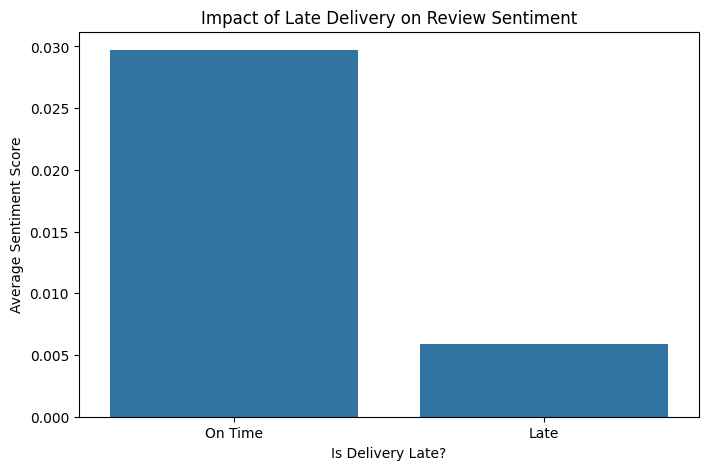

In [13]:
# Drop missing reviews
df_reviews = reviews_df.dropna(subset=['review_comment_message']).copy()

def get_sentiment(text):
    try:
        # For simplicity/demo (assumes English or simple patterns)
        # Real-world: Translate to English first or use Portuguese model
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

df_reviews['sentiment_score'] = df_reviews['review_comment_message'].apply(get_sentiment)
merged_df = pd.merge(df_reviews, orders_df, on='order_id')

plt.figure(figsize=(8, 5))
sns.barplot(x='is_late', y='sentiment_score', data=merged_df, estimator='mean', errorbar=None)

plt.title('Impact of Late Delivery on Review Sentiment')
plt.xlabel('Is Delivery Late?')
plt.ylabel('Average Sentiment Score')
plt.xticks([0, 1], ['On Time', 'Late'])
plt.show()


## 5. Customer Segmentation (RFM Analysis)
To identify the most valuable customers, we will perform RFM Analysis. This involves grouping customers based on three metrics:
* **Recency (R):** How recently did the customer make a purchase?
* **Frequency (F):** How often do they purchase?
* **Monetary (M):** How much do they spend?

In [14]:
# Preparing RFM Data
rfm_data = (
    orders_df
    .merge(items_df, on='order_id')
    .merge(customers_df, on='customer_id')
)
# Selecting only delivered orders
rfm_data = rfm_data[rfm_data['order_status'] == 'delivered']

# Calculating the latest purchase date in the dataset
latest_date = rfm_data['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Aggregating data by Customer Unique ID
rfm_scores = rfm_data.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days, # Recency
    'order_id': 'count',                                                # Frequency
    'price': 'sum'                                                      # Monetary
}).reset_index()

# Renaming columns for clarity
rfm_scores.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'price': 'Monetary'
}, inplace=True)

# Assigning RFM Scores (1-5)
rfm_scores['R_Score'] = pd.qcut(rfm_scores['Recency'], q=5, labels=[5, 4, 3, 2, 1])

# Logic: Most customers buy only once; Score 1: 1 order, Score 2: 2 orders, ... Score 5: 5+ orders
def get_f_score(x):
    if x == 1: return 1
    elif x == 2: return 2
    elif x == 3: return 3
    elif x == 4: return 4
    else: return 5

rfm_scores['F_Score'] = rfm_scores['Frequency'].apply(get_f_score)

# Monetary Score (High money = High Score 5)
rfm_scores['M_Score'] = pd.qcut(rfm_scores['Monetary'], q=5, labels=[1, 2, 3, 4, 5])

# Combining scores into a single string (e.g., "555")
rfm_scores['RFM_Segment'] = rfm_scores.R_Score.astype(str) + rfm_scores.F_Score.astype(str) + rfm_scores.M_Score.astype(str)

# Calculating a total numerical score
rfm_scores['RFM_Score_Total'] = rfm_scores[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

rfm_scores.sample(5)

,customer_unique_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score_Total
21568,3af0b2f7654f613ff1527b997a2ac57e,208,1,19.900,3,1,1,311,5
52028,8ef940c8c63e85e9e2fd65f7e8b6581c,90,1,49.900,5,1,2,512,8
74245,cb5c545d96f39390b7f372aaa88c4a7e,301,2,78.000,2,2,3,223,7
45830,7d6b089029085b9d544174ab78412378,351,1,179.900,2,1,4,214,7
33285,5af79d89508d36628b0796f94afa3fa9,21,1,77.980,5,1,3,513,9


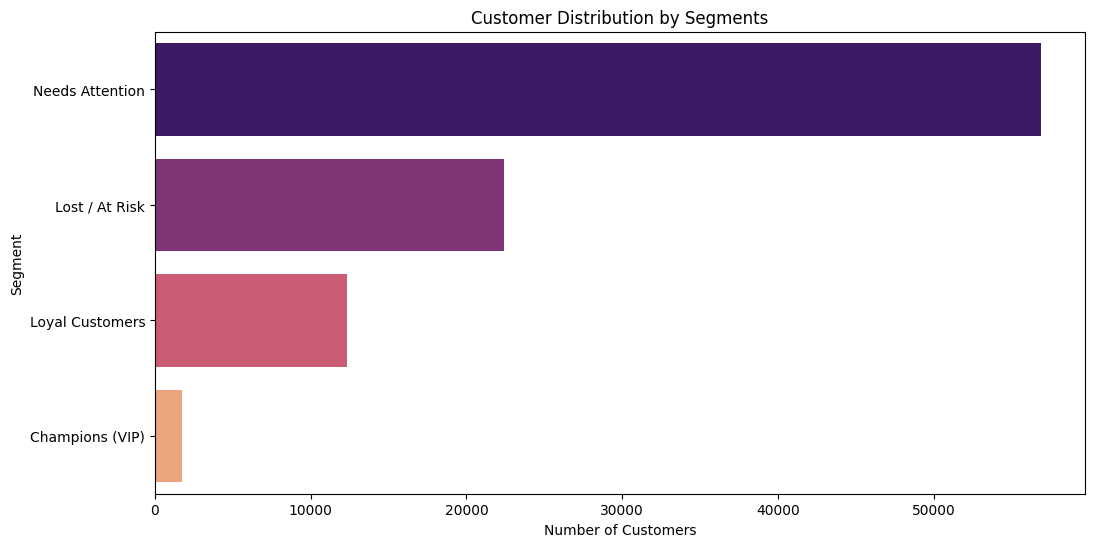

,count
Customer_Segment,
Needs Attention,56854
Lost / At Risk,22433
Loyal Customers,12338
Champions (VIP),1733


In [15]:
# Segmenting Customers Based on RFM Scores
def segment_customer(df):
    if df['RFM_Score_Total'] >= 12:
        return 'Champions (VIP)'
    elif df['RFM_Score_Total'] >= 10:
        return 'Loyal Customers'
    elif df['RFM_Score_Total'] >= 6:
        return 'Needs Attention'
    else:
        return 'Lost / At Risk'

rfm_scores['Customer_Segment'] = rfm_scores.apply(segment_customer, axis=1)

# Visualizing the Segments
plt.figure(figsize=(12, 6))
sns.countplot(y='Customer_Segment', data=rfm_scores, palette='magma', order=rfm_scores['Customer_Segment'].value_counts().index)
plt.title('Customer Distribution by Segments')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()

# Customer segmentation list
rfm_scores['Customer_Segment'].value_counts().to_frame()

## 6. Product Quality Analysis
Analyzing review scores to identify product categories with the lowest customer satisfaction. This helps the business identify quality control issues.

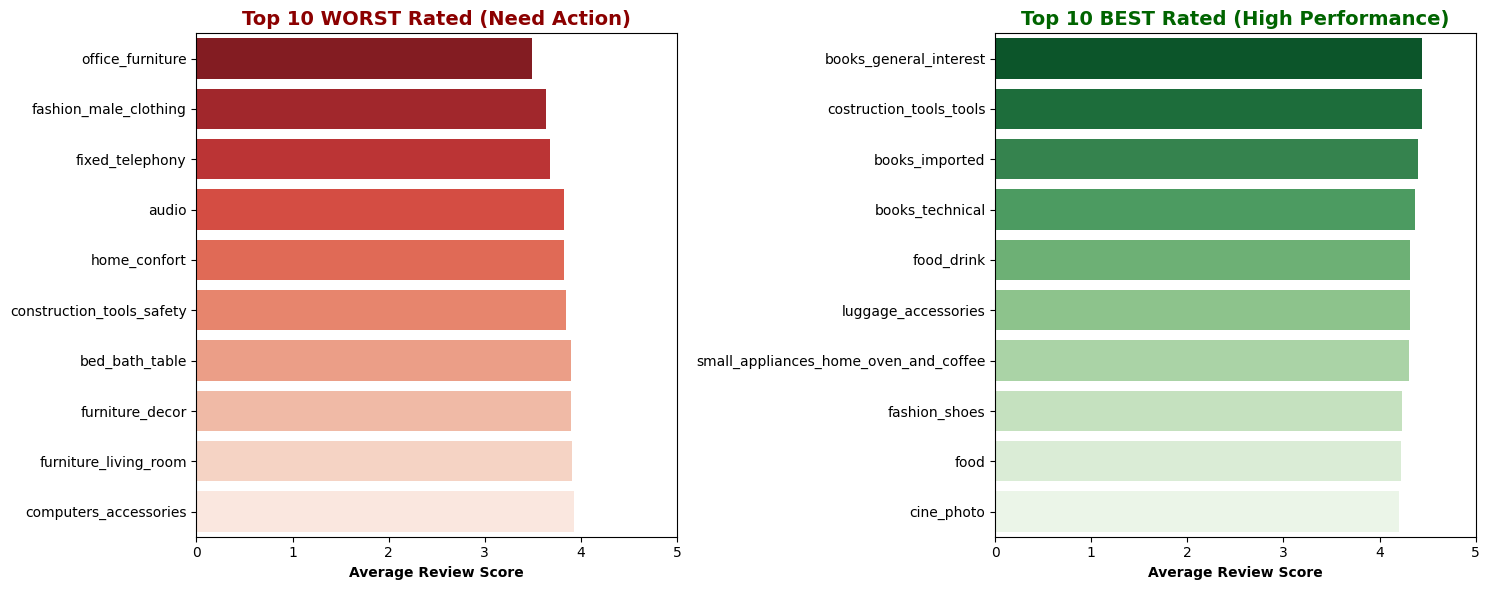

,product_category_name_english,avg_review_score,order_count
46,office_furniture,3.49,1687
25,fashion_male_clothing,3.64,131
28,fixed_telephony,3.68,262
3,audio,3.83,361
38,home_confort,3.83,435
17,construction_tools_safety,3.84,193
6,bed_bath_table,3.90,11137
32,furniture_decor,3.90,8331
33,furniture_living_room,3.90,502
13,computers_accessories,3.93,7849


In [16]:
# Data Preparation; Merge all necessary tables to get product category names and review scores
category_reviews = (
    orders_df.merge(items_df, on='order_id')
    .merge(reviews_df, on='order_id')
    .merge(products_df, on='product_id')
    .merge(category_translation, on='product_category_name', how='left')
    .groupby('product_category_name_english')
    .agg(avg_review_score=('review_score', 'mean'), order_count=('order_id', 'count'))
    .query('order_count > 50')
    .reset_index()
)
worst_categories = category_reviews.nsmallest(10, 'avg_review_score')
best_categories = category_reviews.nlargest(10, 'avg_review_score')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

def plot_category(data, ax, palette, title, color):
    sns.barplot(x='avg_review_score', y='product_category_name_english', data=data, ax=ax, palette=palette)
    ax.set_title(title, fontsize=14, fontweight='bold', color=color)
    ax.set_xlabel('Average Review Score', fontweight='bold')
    ax.set_ylabel('')
    ax.set_xlim(0, 5)

plot_category(worst_categories, axes[0], 'Reds_r', 'Top 10 WORST Rated (Need Action)', 'darkred')
plot_category(best_categories, axes[1], 'Greens_r', 'Top 10 BEST Rated (High Performance)', 'darkgreen')
plt.tight_layout()
plt.show()

# Show in Dataframe
df1_style = worst_categories.style.format({'avg_review_score': '{:.2f}'}) \
    .set_table_attributes("style='display:inline; margin-right:50px'") \
    .set_caption("<b>Top 10 WORST Rated 🔴</b>")

df2_style = best_categories.style.format({'avg_review_score': '{:.2f}'}) \
    .set_table_attributes("style='display:inline'") \
    .set_caption("<b>Top 10 BEST Rated 🟢</b>")

display_html(df1_style._repr_html_() + df2_style._repr_html_(), raw=True)

## 7. Payment Behaviour Analysis
Understanding how customers pay is crucial for financial planning and partnership deals with banks. We will analyze: **Payment Methods** & **Installment Behavior**.

### Preferred Payment Methods
What customers prefer most? Credit Cards, Boleto, or Vouchers?

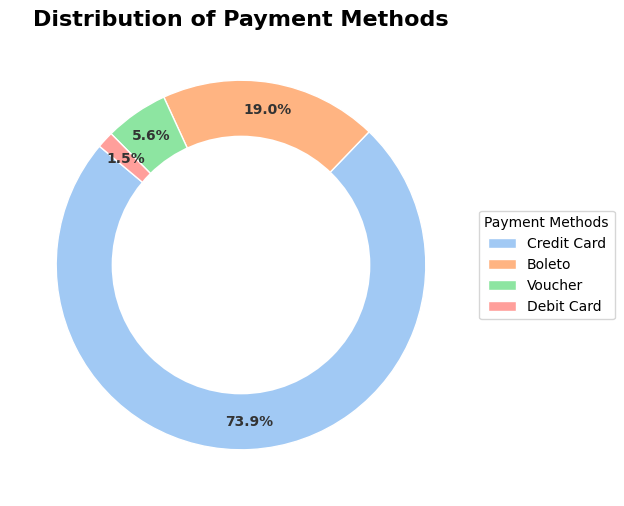

Payment Method,Transactions,Percentage
Credit Card,"76,795",73.9%
Boleto,"19,784",19.0%
Voucher,"5,775",5.6%
Debit Card,"1,529",1.5%


In [17]:
# Prepare Data
payment_counts = payments_df['payment_type'].value_counts()
payment_counts_clean = payment_counts.drop('not_defined', errors='ignore')

# Create a DataFrame for the table
df_payment = pd.DataFrame({
    'Payment Method': payment_counts_clean.index.str.replace('_', ' ').str.title(),
    'Transactions': payment_counts_clean.values,
    'Percentage': (payment_counts_clean.values / payment_counts_clean.values.sum() * 100).round(1)
})
df_payment['Percentage'] = df_payment['Percentage'].astype(str) + '%'

# Visualization
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
wedges, texts, autotexts = ax.pie(
    payment_counts_clean.values, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel'),
    pctdistance=0.85,  # Push % towards the edge
    wedgeprops=dict(width=0.4, edgecolor='white'), # Width makes it a Donut
    textprops={'fontsize': 10, 'fontweight': 'bold', 'color': '#333333'}
)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Legend
ax.legend(wedges, df_payment['Payment Method'],
          title="Payment Methods",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Payment Methods', fontsize=16, fontweight='bold')
plt.show()

# Table Display
display(
    df_payment.style.background_gradient(cmap='Blues', subset=['Transactions'])
    .format({'Transactions': '{:,}'})
    .set_caption("Detailed Breakdown of Payment Methods")
    .set_properties(**{'text-align': 'center'})
    .hide(axis="index")
)

> **Observation:**
> * **Credit Card:** An overwhelming **74%** of customers prefer using Credit Cards, indicating a high trust in digital payments.
> * **Boleto:** The second most popular method is **Boleto (19%)**, which is unique to Brazil. This suggests a significant portion of customers might be unbanked or prefer cash-based digital transactions.
> * **Strategy:** Ensure the credit card gateway is always up, but strictly maintain Boleto support to not lose ~20% of the market.

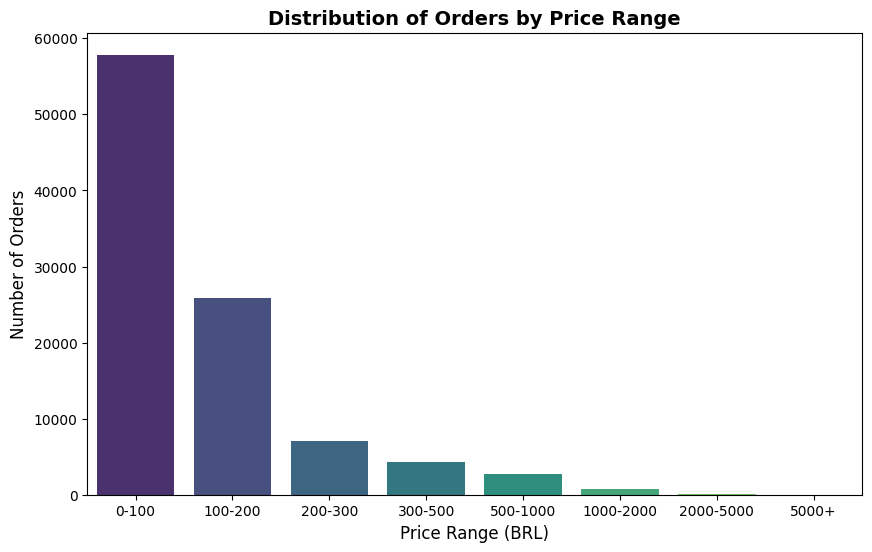

Average Order Value: 137.75 BRL


,0,1,2,3,4,5,6,7
Price_Range_BRL,0-100,100-200,200-300,300-500,500-1000,1000-2000,2000-5000,5000+
Order_Count,57843,25831,7039,4336,2674,799,138,6


In [18]:
# Calculating Average Order Value (AOV)
price_per_order = items_df.groupby('order_id')['price'].sum()
bins = [0, 100, 200, 300, 500, 1000, 2000, 5000, price_per_order.max()]
labels = ['0-100', '100-200', '200-300', '300-500', '500-1000', '1000-2000', '2000-5000', '5000+']
order_ranges = pd.cut(price_per_order, bins=bins, labels=labels).value_counts().reindex(labels).reset_index()
order_ranges.columns = ['Price_Range_BRL', 'Order_Count']
aov = price_per_order.mean()

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Price_Range_BRL', y='Order_Count', data=order_ranges, palette='viridis')

plt.title('Distribution of Orders by Price Range', fontsize=14, fontweight='bold')
plt.xlabel('Price Range (BRL)', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

# for i, val in enumerate(order_ranges['Order_Count']):
#     plt.text(i, val + 500, f'{val}', ha='center', fontsize=10)

# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Average Order Value: {aov:.2f} BRL")
display((order_ranges.T).style.background_gradient(cmap='Blues', axis=1))

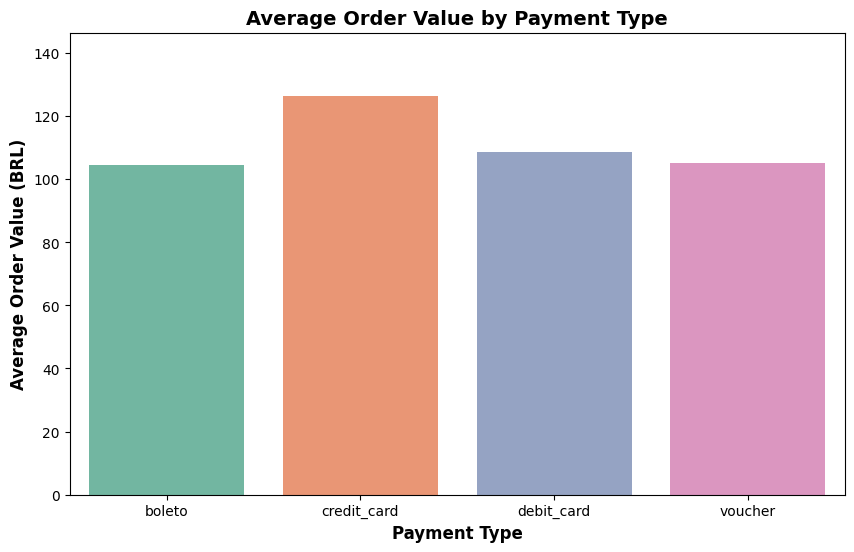

In [19]:
# Averege Order Value by payment type
payment_aov = (
    payments_df.merge(items_df, on='order_id')
    .groupby('payment_type')['price']
    .mean()
    .reset_index()
)
# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='payment_type', y='price', data=payment_aov, palette='Set2')
plt.title('Average Order Value by Payment Type', fontsize=14, fontweight='bold')
plt.xlabel('Payment Type', fontsize=12, fontweight='bold')
plt.ylabel('Average Order Value (BRL)', fontsize=12, fontweight='bold')
plt.ylim(0, payment_aov['price'].max() + 20)
plt.show()

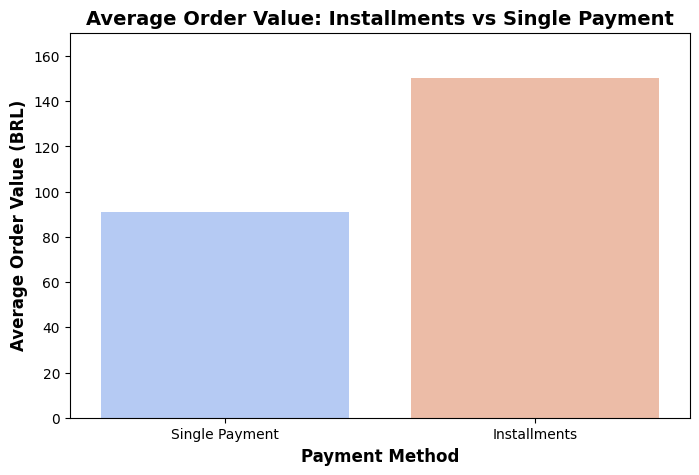

In [20]:
# Calculating AOV for Installments vs Single Payment
merged_df = payments_df.merge(items_df, on='order_id')
merged_df['is_installment'] = merged_df['payment_installments'] > 1
installment_aov = merged_df.groupby('is_installment')['price'].mean().reset_index()

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(
    x='is_installment', 
    y='price', 
    data=installment_aov, 
    palette='coolwarm'
)
plt.xticks([0, 1], ['Single Payment', 'Installments'])
plt.title('Average Order Value: Installments vs Single Payment', fontsize=14, fontweight='bold')
plt.xlabel('Payment Method', fontsize=12, fontweight='bold')
plt.ylabel('Average Order Value (BRL)', fontsize=12, fontweight='bold')
plt.ylim(0, installment_aov['price'].max() + 20)
plt.show()

### Analysis of Installment Distribution
Since installments are strictly associated with **Credit Card** payments, we will filter the dataset to focus solely on credit card transactions. This allows us to understand the preferred installment plans of customers.

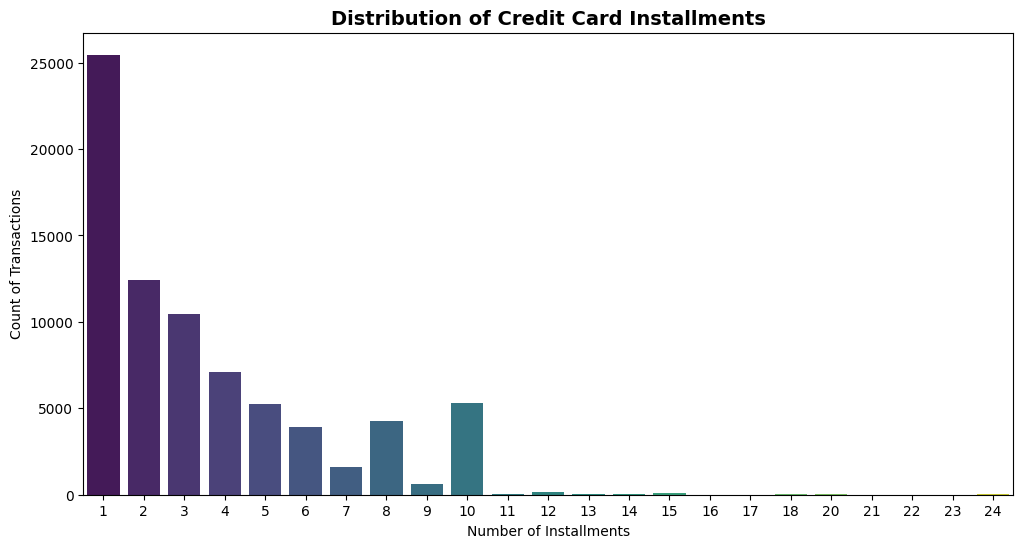

payment_installments,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24
Transaction Count,"25,455","12,413","10,461","7,098","5,239","3,920","1,626","4,268",644,"5,328",23,133,16,15,74,5,8,27,17,3,1,1,18


In [21]:
credit_card_data = payments_df[payments_df['payment_type'] == 'credit_card']
credit_card_data=credit_card_data[credit_card_data['payment_installments']>0]
plt.figure(figsize=(12, 6))
sns.countplot(x='payment_installments', data=credit_card_data, palette='viridis')

plt.title('Distribution of Credit Card Installments', fontweight='bold', fontsize=14)
plt.xlabel('Number of Installments')
plt.ylabel('Count of Transactions')
plt.show()

display((credit_card_data['payment_installments'].value_counts().sort_index().to_frame(name='Transaction Count').T)
        .style.background_gradient(cmap='Blues', axis=1).format("{:,}"))

## 8. **Seller Analysis**
Identifying key sellers who drive the most revenue. This helps in managing supplier relationships and identifying potential partnerships.

### **Top Seller Analysis**

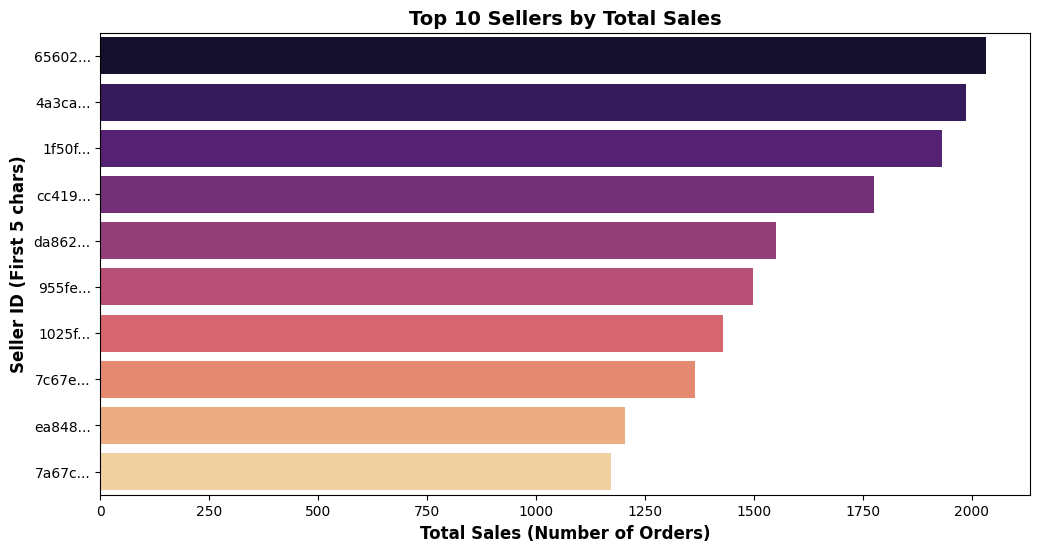

Top 5 Sellers Sales:


,seller_id,order_id
1235,6560211a19b47992c3666cc44a7e94c0,2033
881,4a3ca9315b744ce9f8e9374361493884,1987
368,1f50f920176fa81dab994f9023523100,1931
2481,cc419e0650a3c5ba77189a1882b7556a,1775
2643,da8622b14eb17ae2831f4ac5b9dab84a,1551


In [22]:
# Total Sales per seller
sell_count = items_df.groupby('seller_id')['order_id'].count().reset_index()
top_sellers = sell_count.sort_values('order_id', ascending=False).head(10)
top_sellers['short_id'] = top_sellers['seller_id'].str[:5] + '...' 

# Visualizing ---
plt.figure(figsize=(12, 6))
sns.barplot(x='order_id', y='short_id', data=top_sellers, palette='magma')

plt.title('Top 10 Sellers by Total Sales', fontsize=14, fontweight='bold')
plt.xlabel('Total Sales (Number of Orders)', fontsize=12, fontweight='bold')
plt.ylabel('Seller ID (First 5 chars)', fontsize=12, fontweight='bold')
plt.show()

# Checking the exact revenue numbers
print("Top 5 Sellers Sales:")
display(top_sellers[['seller_id', 'order_id']].head(5))

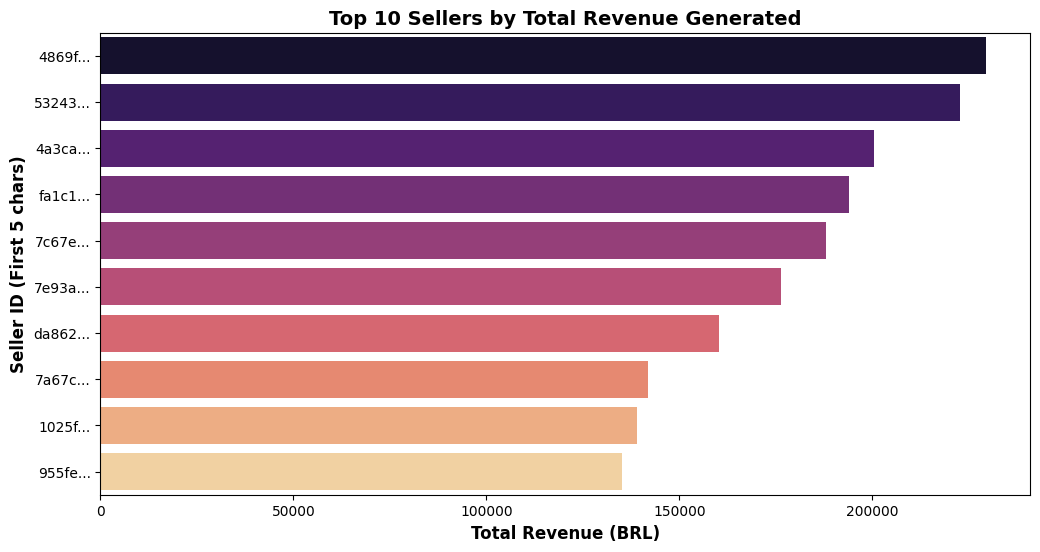

Top 5 Sellers Revenue:


,seller_id,price
857,4869f7a5dfa277a7dca6462dcf3b52b2,229472.630
1013,53243585a1d6dc2643021fd1853d8905,222776.050
881,4a3ca9315b744ce9f8e9374361493884,200472.920
3024,fa1c13f2614d7b5c4749cbc52fecda94,194042.030
1535,7c67e1448b00f6e969d365cea6b010ab,187923.890


In [23]:
# Calculating Revenue per Seller
seller_performance = items_df.groupby('seller_id')['price'].sum().reset_index()
top_sellers = seller_performance.sort_values('price', ascending=False).head(10)
top_sellers['short_id'] = top_sellers['seller_id'].str[:5] + '...' 

# Visualizing ---
plt.figure(figsize=(12, 6))
sns.barplot(x='price', y='short_id', data=top_sellers, palette='magma')

plt.title('Top 10 Sellers by Total Revenue Generated', fontsize=14, fontweight='bold')
plt.xlabel('Total Revenue (BRL)', fontsize=12, fontweight='bold')
plt.ylabel('Seller ID (First 5 chars)', fontsize=12, fontweight='bold')
plt.show()

# Checking the exact revenue numbers
print("Top 5 Sellers Revenue:")
display(top_sellers[['seller_id', 'price']].head())

### **Seller Concentration Analysis**

In [24]:
# Calculte 80% of total revenue come from how many sellers
total_revenue = items_df['price'].sum()
seller_revenue = items_df.groupby('seller_id')['price'].sum().reset_index()
seller_revenue = seller_revenue.sort_values('price', ascending=False).reset_index(drop=True)
seller_revenue['cumulative_revenue'] = seller_revenue['price'].cumsum()
seller_revenue['cumulative_percentage'] = (seller_revenue['cumulative_revenue'] / total_revenue) * 100
sellers_80_percent = seller_revenue[seller_revenue['cumulative_percentage'] <= 80]
print(f"Total Revenue: {total_revenue:.2f} BRL")
print(f"Number of Sellers contributing to 80% of Revenue: {len(sellers_80_percent)} out of {len(seller_revenue)} total sellers ({len(sellers_80_percent)/len(seller_revenue)*100:.2f}%)")

Total Revenue: 13591643.70 BRL
Number of Sellers contributing to 80% of Revenue: 543 out of 3095 total sellers (17.54%)


>**Alarming!**
> 80% of total revenue comes from a small group of sellers (~20%), indicating high dependence on a few top performers.
> This level of concentration is alarming and creates significant business risk if these sellers churn.


## 9. Regional Analysis: Revenue, Volume & Freight Costs

In this section, we analyze Olist's market performance across different Brazilian states. Instead of looking at a single metric, we break down the regional data into three key dimensions:

1.  **Total Revenue by State:** To identify the most profitable regions and financial strongholds.
2.  **Sales Volume by State:** To understand customer demand density and market penetration.
3.  **Average Freight Cost:** To evaluate logistical efficiency and shipping affordability across states.
4.  **Geographical Analysis** We visualize the geographical footprint of Olist's market. We use a **scatterplot** to map the density of customer locations across Brazil.
5.  **Customer per Seller by State** To identify supply gaps across different states.
This comparative analysis allows us to correlate financial success with physical demand and identify logistical challenges in specific regions.

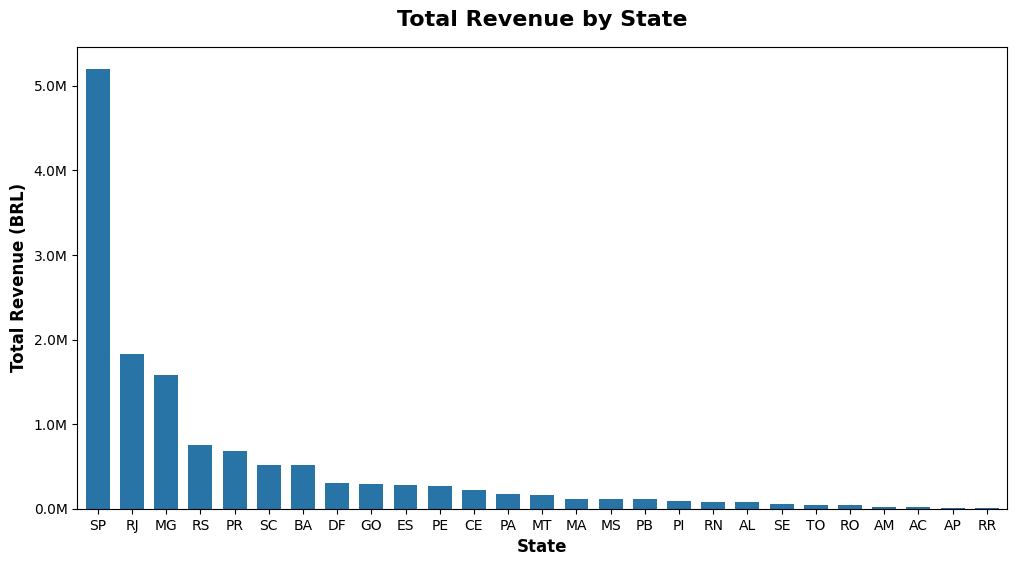

In [25]:
# Prepare Data
revenue_data = orders_df.merge(items_df, on='order_id').merge(customers_df, on='customer_id')
state_revenue = revenue_data.groupby('customer_state')['price'].sum().sort_values(ascending=False)
state_sales = revenue_data.groupby('customer_state')['order_id'].nunique().sort_values(ascending=False)

# Freight Cost by State
freight_data = orders_df.merge(items_df, on='order_id').merge(customers_df, on='customer_id')
state_freight = freight_data.groupby('customer_state')['freight_value'].mean().sort_values(ascending=False) 
avg_freight = freight_data['freight_value'].mean()

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
state_revenue.plot(kind='bar', color='#2874A6', ax=ax, width=0.7)

ax.set_title("Total Revenue by State", fontsize=16, fontweight='bold', pad=15)
ax.set_ylabel("Total Revenue (BRL)", fontsize=12, fontweight='bold')
ax.set_xlabel("State", fontsize=12, fontweight='bold')
# ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.tick_params(axis='x', rotation=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1f}M".format(x/1e6)))
# sns.despine(top=True, right=True)
plt.show()

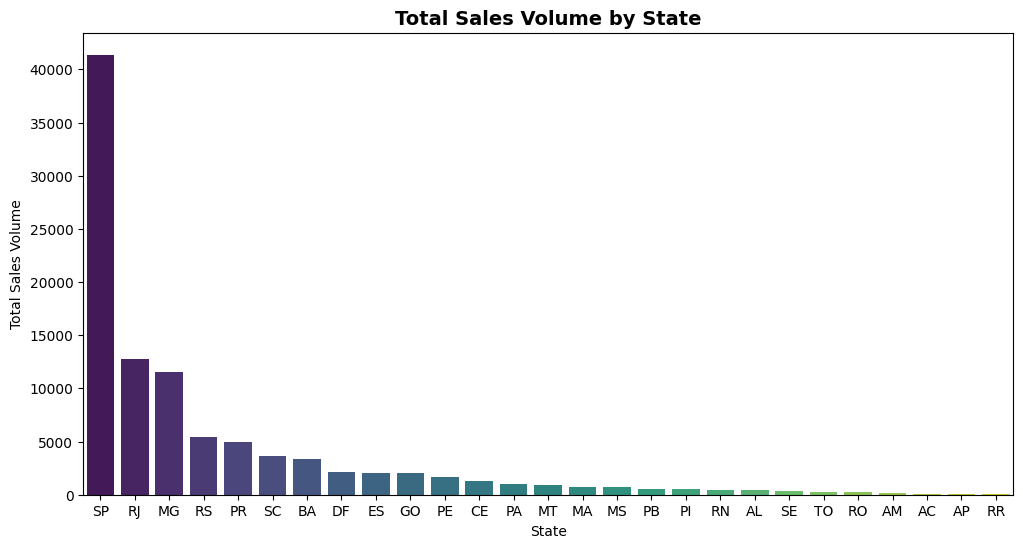

In [26]:
# Total Sales Volume by State
state_sales = revenue_data.groupby('customer_state')['order_id'].nunique().sort_values(ascending=False)
# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=state_sales.index, y=state_sales.values, palette='viridis')
plt.title('Total Sales Volume by State', fontsize=14, fontweight='bold')
plt.xlabel('State')
plt.ylabel('Total Sales Volume')
plt.show()

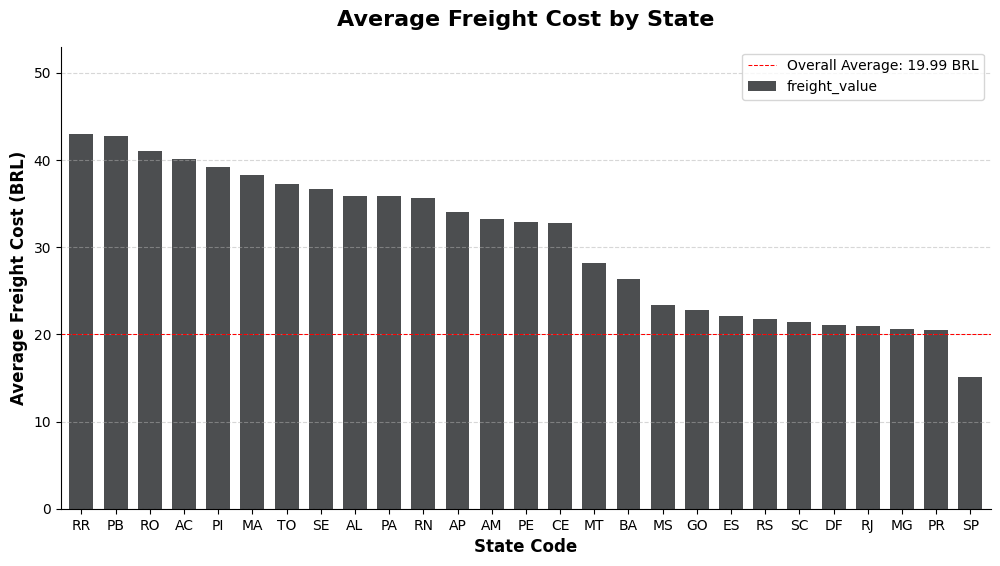

In [27]:
# Visualization for Average Freight Cost by State
fig, ax = plt.subplots(figsize=(12, 6))
state_freight.plot(kind='bar', color="#4C4E50", ax=ax, width=0.7)
ax.set_title("Average Freight Cost by State", fontsize=16, fontweight='bold', pad=15)
ax.set_ylabel("Average Freight Cost (BRL)", fontsize=12, fontweight='bold')
ax.set_xlabel("State Code", fontsize=12, fontweight='bold')
ax.axhline(avg_freight, color='red', linestyle='--', linewidth=0.75, label=f'Overall Average: {avg_freight:.2f} BRL')
ax.set_ylim(0, state_freight.max() + 10)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend()
sns.despine(top=True, right=True)
plt.show()

In [28]:
# Summary Table
summary_df = pd.concat([state_revenue, state_sales, state_freight], axis=1, keys=['Total Revenue (BRL)', 'Total Sales Volume', 'Average Freight Cost (BRL)']).T

idx = pd.IndexSlice
summary_df.style.background_gradient(cmap='Blues', axis=1, subset=idx[['Total Revenue (BRL)'], :])\
                .background_gradient(cmap='Blues', axis=1, subset=idx[['Total Sales Volume'], :])\
                .background_gradient(cmap='Reds', axis=1, subset=idx[['Average Freight Cost (BRL)'], :])\
                .format("{:,.0f}")

customer_state,SP,RJ,MG,RS,PR,SC,BA,DF,GO,ES,PE,CE,PA,MT,MA,MS,PB,PI,RN,AL,SE,TO,RO,AM,AC,AP,RR
Total Revenue (BRL),"5,202,955","1,824,093","1,585,308","750,304","683,084","520,553","511,350","302,604","294,592","275,037","262,788","227,255","178,948","156,454","119,648","116,813","115,268","86,914","83,035","80,315","58,921","49,622","46,141","22,357","15,983","13,474","7,829"
Total Sales Volume,"41,375","12,762","11,544","5,432","4,998","3,612","3,358","2,125","2,007","2,025","1,648","1,327",970,903,740,709,532,493,482,411,345,279,247,147,81,68,46
Average Freight Cost (BRL),15,21,21,22,21,21,26,21,23,22,33,33,36,28,38,23,43,39,36,36,37,37,41,33,40,34,43


### Geospatial Analysis: Customer Density Map
To understand the geographical reach of Olist, we visualize the distribution of customers across Brazil.

**Key Steps:**
1.  **Coordinate Cleaning:** We applied a strict **Bounding Box** (Lat/Long limits) to filter out GPS errors that pointed to locations outside Brazil.
2.  **Data Integration:** Merged customer records with unique geolocation data based on Zip Codes.
3.  **Visualization:** The scatterplot below represents customer density, highlighting key market hubs.

Mapped Customers: 99162


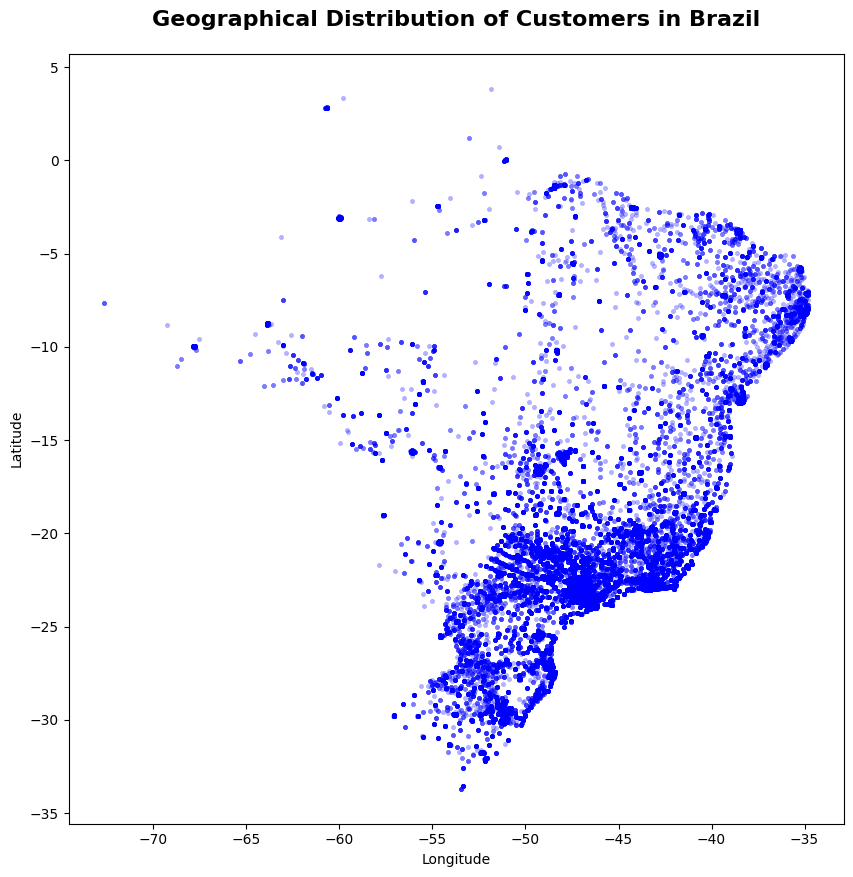

In [29]:
# --- Preparing Data ---
geo_data = geo_data[
    (geo_data.geolocation_lat <= 5.27438888) & 
    (geo_data.geolocation_lat >= -33.75116944) & 
    (geo_data.geolocation_lng >= -73.98283055) & 
    (geo_data.geolocation_lng <= -34.79314722)
]
# Keeping only unique zip code prefixes
geo_unique = geo_data.drop_duplicates(subset=['geolocation_zip_code_prefix'])

# Merging & Linking customers to their location
customer_loc_df = customers_df.merge(geo_unique, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
# Checking the number of mapped customers
print(f"Mapped Customers: {customer_loc_df.shape[0]}")
# --- Visualizing the Map ---
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x='geolocation_lng', 
    y='geolocation_lat', 
    data=customer_loc_df, 
    alpha=0.3,         
    s=10,             
    color='blue',       
    edgecolor=None      
)
plt.title('Geographical Distribution of Customers in Brazil', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [30]:
# ---  Interactive Heatmap ---
# Keeping only unique zip code prefixes
heat_data = geo_data.drop_duplicates(subset=['geolocation_zip_code_prefix'])[['geolocation_lat', 'geolocation_lng']]

# Create Map centered on Brazil
map_brazil = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# Add Heatmap Layer
HeatMap(heat_data, radius=15, blur=20).add_to(map_brazil)

#Show
map_brazil

### Market Opportunity: Supply vs. Demand
We calculate the **Customers-per-Seller ratio** to identify supply gaps across different states.
> **Insight:** States with a **high ratio** indicate high demand but low seller saturation, signaling a strategic opportunity for **new seller recruitment**.

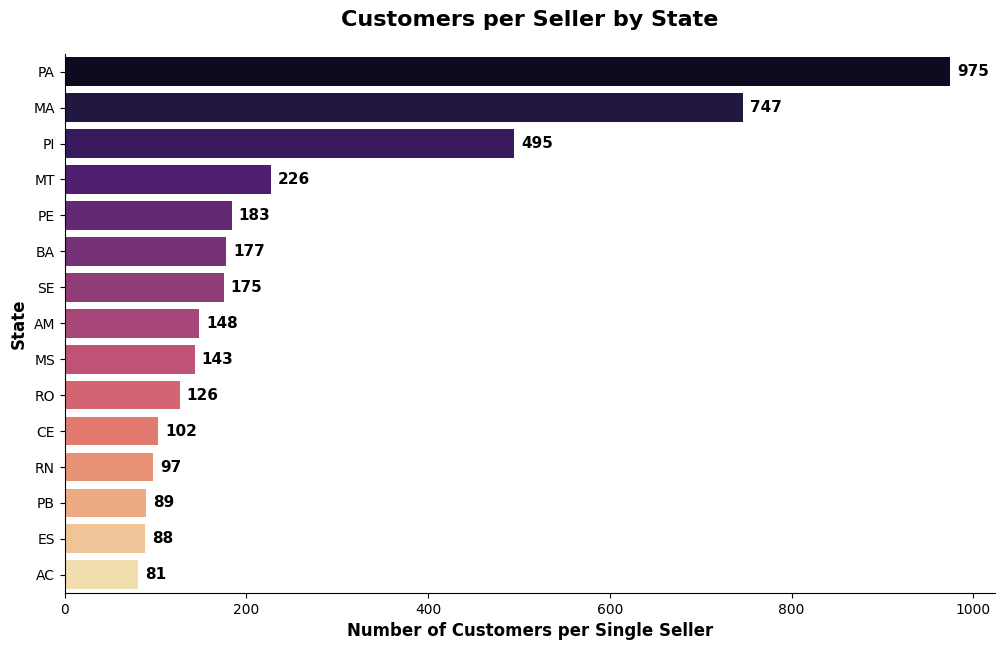

    Customers  Sellers  Customers_per_Seller
PA        975    1.000               975.000
MA        747    1.000               747.000
PI        495    1.000               495.000
MT        907    4.000               226.750
PE       1652    9.000               183.556


In [31]:
# Prepare Data
cust_counts = customers_df['customer_state'].value_counts()
seller_counts = sellers_df['seller_state'].value_counts()

# Merge into one DataFrame & clean
market = pd.DataFrame({'Customers': cust_counts, 'Sellers': seller_counts})
market = market.dropna()

# Calculate Ratio
market['Customers_per_Seller'] = market['Customers'] / market['Sellers']
market = market.sort_values(by='Customers_per_Seller', ascending=False).head(15)

# Visualization
plt.figure(figsize=(12, 7), dpi=100)

ax = sns.barplot(
    x=market['Customers_per_Seller'], 
    y=market.index, 
    palette='magma'
)
plt.title('Customers per Seller by State', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Customers per Single Seller', fontsize=12, fontweight='bold')
plt.ylabel('State', fontsize=12, fontweight='bold')

# Add Data Labels
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}', 
                (width, p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                fontsize=11, color='black', fontweight='bold', 
                xytext=(5, 0), textcoords='offset points')
sns.despine()
plt.show()

# Insight Print
print(market[['Customers', 'Sellers', 'Customers_per_Seller']].head(5))

----
# **Final Executive Verdict**

### Elevator Pitch
Olist demonstrates strong market demand but is constrained by operational inefficiencies. Sustainable profitability will not come from further user acquisition alone, but from resolving logistics failures in remote regions and improving retention of high-value customers.

---

## Strategic Action Plan: Three Pillars

### 1. Optimize Operational Resilience (Logistics & Quality)

**Problem**
Data reveals that **regional logistic bottlenecks** and **quality failures in specific categories** are the primary drivers of customer attrition, actively eroding brand equity.

**Action**
* **Supplier Rationalization:** Enforce a strict **"Three-Strike Policy"** to immediately de-list sellers with high return rates or shipping delays.
* **Logistics Calibration:** Renegotiate SLAs in high-latency zones and restrict sales in regions where on-time delivery cannot be guaranteed.

---

### 2. Focus on High-Value Customers (RFM and Demand Trends)

**Problem**  
Approximately 96% of customers make only a single purchase, indicating weak retention.

**Action**  
Reallocate marketing spend from mass acquisition to retention, prioritizing high-RFM segments (Champions). Execute campaigns during [Peak Day/Hour identified from demand analysis] to maximize ROI.

---

### 3. Expand Selectively Based on Supply–Demand Gaps

**Problem**  
Several regions show high customer demand but insufficient local seller supply, leading to higher delivery times and costs.

**Action**  
Recruit local sellers in states with elevated Customers-per-Seller ratios to reduce logistics cost and improve delivery performance.

---

## **Conclusion**
Long-term profitability depends on operational discipline rather than top-line growth alone. Address logistics failures, retain high-value customers, and expand only where supply and demand are structurally aligned.


In [32]:
!jupyter nbconvert --to markdown "Olist_Ecommerce_Analysis.ipynb"

[NbConvertApp] Converting notebook Olist_Ecommerce_Analysis.ipynb to markdown
[NbConvertApp] Support files will be in Olist_Ecommerce_Analysis_files\
[NbConvertApp] Writing 914655 bytes to Olist_Ecommerce_Analysis.md
